Copyright 2025 The Institute of Cancer Research.

Licensed under a software academic use license provided with this software package (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at: https://github.com/CalumGabbutt/evoflux
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and limitations under the License.


# fCpG discovery pipeline - example using lymphoid cancer data

In this notebook, I demonstrate how to discover a set of fluctuating CpGs (fCpGs) from methylation bead array data. We will use the harmonised data matrix of 2,204 samples employed in Gabbutt, Duran-Ferrer et al (2025).

First let's import the modules that we will use in this notebook:

In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit
from evoflux import evofcpgs as ef
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

The full data matrix is too large to bundle with Github and is stored at Zenodo (https://doi.org/10.5281/zenodo.15479736). First, let's download the data. The data file is ~7GB, so depending on your download speeds this may take some time... 

In [2]:
!curl -L -o QC_2204_metadata.csv https://zenodo.org/api/records/15479737/files/QC_2204_metadata.csv/content
!curl -L -o QC_2204_ssNob.tsv.zip https://zenodo.org/api/records/15479737/files/QC_2204_ssNob.tsv.zip/content

Now that the data is downloaded, let's load it.

In [3]:
beta_all = ef.read_largest_tsv_from_zip("QC_2204_ssNob.tsv.zip")
sampleinfo = pd.read_csv("QC_2204_metadata.csv", index_col = 0)
sampleinfo

,PARTICIPANT_ID,SAMPLE_ID,SAME_SAMPLE_ANONYMOUS,SAME_SAMPLE_ID,SAMPLE_TIMEPOINTS,CELL_TYPE,CELL_TYPE_ANNOT_1,CELL_TYPE_ANNOT_2,CELL_TYPE_ANNOT_3,SOURCE,...,CENTER,CENTER_2,WES,WGS,RNA_SEQ,PLATFORM,SLIDE,ARRAY,PMID,REPOSITORY
PARTICIPANT_ID_ANONYMOUS,,,,,,,,,,,,,,,,,,,,,
NBC-01,T11/6_NBC,T11/6_NBC,NaN,NaN,NaN,Naive_Bcell,Normal_lymphoid_cell,NBC,Bcell,Tonsil,...,NaN,NaN,False,False,False,Illumina-450k,6.929671e+09,R04C01,26053498,EGAS00001001196
NBC-02,932-01-4D-Naive,932-01-4D-Naive,NaN,NaN,NaN,Naive_Bcell,Normal_lymphoid_cell,NBC,Bcell,PB,...,NaN,NaN,False,False,False,Illumina-450k,5.900833e+09,R01C02,26053498,EGAS00001001196
NBC-03,938-01-1D-Naive,938-01-1D-Naive,NaN,NaN,NaN,Naive_Bcell,Normal_lymphoid_cell,NBC,Bcell,PB,...,NaN,NaN,False,False,False,Illumina-450k,5.900833e+09,R01C01,26053498,EGAS00001001196
NBC-04,939-01-1D-Naive,939-01-1D-Naive,NaN,NaN,NaN,Naive_Bcell,Normal_lymphoid_cell,NBC,Bcell,PB,...,NaN,NaN,False,False,False,Illumina-450k,5.900833e+09,R04C01,26053498,EGAS00001001196
NBC-05,T11/8_NBC,T11/8_NBC,NaN,NaN,NaN,Naive_Bcell,Normal_lymphoid_cell,NBC,Bcell,Tonsil,...,NaN,NaN,False,False,False,Illumina-450k,6.929671e+09,R04C02,26053498,EGAS00001001196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PBMC-02,PBMC.1,PBMC.1,NaN,NaN,NaN,Peripheral_blood_mononuclear_cells,PBMCs,PBMCs,PBMCs,PB,...,Reinius_2012,Reinius_2012,False,False,False,Illumina-450k,5.684819e+09,R05C01,22848472,GSE35069
PBMC-03,PBMC.2,PBMC.2,NaN,NaN,NaN,Peripheral_blood_mononuclear_cells,PBMCs,PBMCs,PBMCs,PB,...,Reinius_2012,Reinius_2012,False,False,False,Illumina-450k,5.684819e+09,R06C01,22848472,GSE35069
PBMC-04,PBMC.3,PBMC.3,NaN,NaN,NaN,Peripheral_blood_mononuclear_cells,PBMCs,PBMCs,PBMCs,PB,...,Reinius_2012,Reinius_2012,False,False,False,Illumina-450k,5.727920e+09,R04C01,22848472,GSE35069


Use the metadata stored in the Github repo to allocate samples to the training group

In [4]:
metadata = pd.read_csv('data/BloodMethMetadata.csv', index_col = 0)
training_samples = metadata.loc[metadata['SAMPLE_TRAINING_MODEL']].index
sampleinfo['SAMPLE_TRAINING_MODEL'] = sampleinfo.index.isin(training_samples)

Use the processing function to remove sex specific probes and cross-reactive probes.

In [5]:
beta_candidate, sampleinfo_training = ef.process_data(beta_all, sampleinfo, array='450K')

In [6]:
beta_candidate

PARTICIPANT_ID_ANONYMOUS,MCL-001,MCL-002,MCL-003,MCL-004,MCL-005,MCL-006,MCL-007,MCL-008,MCL-009,MCL-010,...,MM-095,MM-096,MM-097,MM-098,MM-099,MM-100,MM-101,MM-102,MM-103,MM-104
cg00000165,0.044880,0.090604,0.090803,0.616792,0.102534,0.158645,0.077534,0.560117,0.562288,0.256423,...,0.453993,0.125935,0.294733,0.173673,0.052746,0.067335,0.478194,0.103118,0.069344,0.387973
cg00000363,0.562912,0.890893,0.940074,0.610456,0.221399,0.234765,0.154303,0.155214,0.496340,0.106339,...,0.211479,0.566340,0.437396,0.151154,0.527881,0.110319,0.814206,0.143355,0.159258,0.439268
cg00000957,0.902671,0.917504,0.905529,0.904608,0.902527,0.904421,0.920503,0.909929,0.908308,0.917272,...,0.930039,0.895874,0.852699,0.883037,0.845938,0.886788,0.706512,0.856417,0.809584,0.899089
cg00001364,0.900573,0.906468,0.925134,0.908640,0.920162,0.932397,0.917367,0.935041,0.937847,0.876631,...,0.480133,0.828613,0.797061,0.573296,0.775091,0.905070,0.572009,0.655533,0.574863,0.638937
cg00001446,0.485149,0.912196,0.931037,0.925625,0.904981,0.926939,0.915922,0.214671,0.928006,0.933000,...,0.526542,0.912480,0.911688,0.927839,0.833567,0.733208,0.900942,0.865547,0.908712,0.914936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27656573,0.802913,0.916499,0.921974,0.954970,0.617570,0.936112,0.941537,0.653725,0.907016,0.907893,...,0.811530,0.951357,0.928775,0.697362,0.852201,0.928479,0.891331,0.907861,0.592927,0.949189
cg27657363,0.873907,0.901029,0.890662,0.840908,0.892622,0.879018,0.903913,0.907613,0.545017,0.886595,...,0.582313,0.542921,0.702042,0.708909,0.625132,0.392729,0.440751,0.476188,0.704834,0.461044
cg27657537,0.031450,0.062123,0.067009,0.076056,0.092878,0.074604,0.084451,0.067172,0.068153,0.044573,...,0.086384,0.128470,0.066904,0.126688,0.200231,0.087787,0.394132,0.106331,0.118406,0.438225
cg27662611,0.032979,0.053855,0.062517,0.059112,0.048104,0.053043,0.058205,0.046269,0.041582,0.056847,...,0.055898,0.047625,0.097133,0.055752,0.058273,0.049208,0.063315,0.056076,0.056928,0.074769


Calculate the heterogeneity, the mean distance from 0.5 and the Laplacian Score metrics

In [7]:
avg_stds, avg_distance_from_05 = ef.calculate_stats(beta_candidate, sampleinfo_training)

lap_feature = ef.calculate_laplacian_score(beta_candidate)

Constructing the affinity matrix took 22.605 secs
Calculating the Laplacian feature score took 49.230 secs


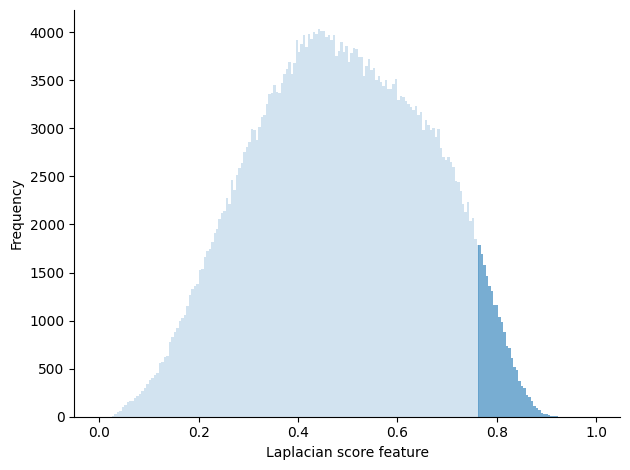

In [10]:
lap_feature_thresh = np.percentile(lap_feature, 95)

fig, ax = plt.subplots()
plt.hist(lap_feature, bins = np.arange(0, np.percentile(lap_feature, 95) + 0.005, 0.005), 
         alpha = 0.2, color = 'tab:blue')
plt.hist(lap_feature, bins = np.arange(np.percentile(lap_feature, 95), 1, 0.005), 
         alpha = 0.6, color = 'tab:blue')
plt.xlabel('Laplacian score feature')
plt.ylabel('Frequency')

sns.despine()
plt.tight_layout()


Now combine all these metrics to define the set of fCpGs

In [11]:
beta_fcpgs = ef.filter_for_fcpgs(beta_candidate, lap_feature, avg_stds, 
                     avg_distance_from_05)

beta_fcpgs

(978, 1471)


PARTICIPANT_ID_ANONYMOUS,MCL-001,MCL-002,MCL-003,MCL-004,MCL-005,MCL-006,MCL-007,MCL-008,MCL-009,MCL-010,...,MM-095,MM-096,MM-097,MM-098,MM-099,MM-100,MM-101,MM-102,MM-103,MM-104
cg00405069,0.439996,0.481469,0.491245,0.891109,0.475548,0.800518,0.146196,0.839035,0.881743,0.485794,...,0.501867,0.718282,0.699005,0.580848,0.809022,0.175969,0.846162,0.496553,0.829355,0.510831
cg00597687,0.458348,0.859797,0.935908,0.422964,0.752630,0.267073,0.494678,0.117027,0.934165,0.108165,...,0.172641,0.600573,0.183978,0.486293,0.088604,0.550162,0.109322,0.391709,0.399605,0.604508
cg00729875,0.527081,0.163540,0.239722,0.809542,0.454082,0.251616,0.875148,0.463978,0.043391,0.462364,...,0.467687,0.125465,0.169600,0.531142,0.042086,0.621849,0.152671,0.283336,0.165734,0.201946
cg01730064,0.045379,0.718172,0.663384,0.700156,0.173397,0.649157,0.690838,0.591557,0.823737,0.654521,...,0.782188,0.724326,0.869380,0.890240,0.108392,0.545444,0.782052,0.683333,0.931590,0.918596
cg01768082,0.409182,0.935105,0.566419,0.539321,0.535490,0.517726,0.517990,0.559960,0.476146,0.593498,...,0.571860,0.599988,0.806048,0.701677,0.504728,0.522202,0.531033,0.855122,0.110556,0.639379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg20548231,0.099337,0.041298,0.561399,0.044286,0.525513,0.246798,0.249966,0.572858,0.563561,0.448887,...,0.576963,0.246771,0.142691,0.606079,0.562755,0.056361,0.615182,0.544672,0.569629,0.633088
cg21401457,0.052492,0.933316,0.063913,0.081654,0.155056,0.271072,0.193686,0.146571,0.923833,0.116879,...,0.066563,0.175287,0.613303,0.256294,0.098343,0.081750,0.273495,0.635934,0.120779,0.896140
cg24435209,0.454836,0.888068,0.910817,0.864158,0.513536,0.520915,0.940579,0.704241,0.501616,0.853998,...,0.217000,0.419208,0.391746,0.596928,0.488212,0.324690,0.250556,0.395273,0.440280,0.232336
cg25163076,0.373124,0.931433,0.932828,0.935175,0.177180,0.850358,0.552639,0.459840,0.525475,0.478258,...,0.528408,0.418396,0.662673,0.443589,0.490414,0.406456,0.802267,0.350435,0.880549,0.452345


But these are only the fCpGs in the training data, so not let's extract the fCpGs from the full set of data

In [12]:
beta_fcpgs_all = beta_all.loc[beta_fcpgs.index]
beta_fcpgs_all

,NBC-01,NBC-02,NBC-03,NBC-04,NBC-05,NBC-06,NBC-07,NBC-08,NBC-09,NBC-10,...,MM-095,MM-096,MM-097,MM-098,MM-099,MM-100,MM-101,MM-102,MM-103,MM-104
cg00405069,0.557178,0.550914,0.548601,0.555167,0.563102,0.592744,0.579481,0.524390,0.591531,0.566458,...,0.501867,0.718282,0.699005,0.580848,0.809022,0.175969,0.846162,0.496553,0.829355,0.510831
cg00597687,0.352295,0.363037,0.406288,0.357619,0.381049,0.414692,0.371031,0.363721,0.379636,0.336937,...,0.172641,0.600573,0.183978,0.486293,0.088604,0.550162,0.109322,0.391709,0.399605,0.604508
cg00729875,0.485887,0.523315,0.521744,0.391359,0.538842,0.445977,0.431575,0.489131,0.561843,0.534735,...,0.467687,0.125465,0.169600,0.531142,0.042086,0.621849,0.152671,0.283336,0.165734,0.201946
cg01730064,0.663272,0.724655,0.801184,0.824238,0.738116,0.773821,0.763756,0.842574,0.775849,0.851588,...,0.782188,0.724326,0.869380,0.890240,0.108392,0.545444,0.782052,0.683333,0.931590,0.918596
cg01768082,0.535030,0.654827,0.585883,0.657136,0.605457,0.654909,0.563825,0.590635,0.562019,0.475528,...,0.571860,0.599988,0.806048,0.701677,0.504728,0.522202,0.531033,0.855122,0.110556,0.639379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg20548231,0.368487,0.445235,0.566593,0.439960,0.553379,0.470197,0.360973,0.381589,0.502195,0.413993,...,0.576963,0.246771,0.142691,0.606079,0.562755,0.056361,0.615182,0.544672,0.569629,0.633088
cg21401457,0.402203,0.497535,0.244948,0.743501,0.428391,0.661520,0.541753,0.438211,0.730256,0.634258,...,0.066563,0.175287,0.613303,0.256294,0.098343,0.081750,0.273495,0.635934,0.120779,0.896140
cg24435209,0.596279,0.612266,0.659924,0.542631,0.666429,0.609801,0.605558,0.672289,0.625147,0.550940,...,0.217000,0.419208,0.391746,0.596928,0.488212,0.324690,0.250556,0.395273,0.440280,0.232336
cg25163076,0.550022,0.661930,0.568753,0.497043,0.559289,0.588086,0.527115,0.622293,0.708978,0.623942,...,0.528408,0.418396,0.662673,0.443589,0.490414,0.406456,0.802267,0.350435,0.880549,0.452345
